In [1]:
import numba
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sf


#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
plt.style.use('bmh')


# Adding noise from the resonators
# smoothing on the quasi target sweep

In [2]:
# Current VNA Model
def modelLoopbackSweep(freqs=None, fi=350e6, ff=850e6, amp_max=300e5, N=500000):
    # just modelling magnitude for now... not sure how to do complex
    if type(freqs) == np.ndarray:
        fi = np.min(freqs)
        ff = np.max(freqs)
        N = np.size(freqs)
    else:
        freqs = np.linspace(fi, ff, N)
    def model(x, fi, ff, amp_max, n=20, slope=0.1):
        # n is fall-off factor
        a = -(fi + ff)/2
        g = (ff - fi)/2
        z = (x + a)/g
        return amp_max*(-z**n - slope*(z + 1) + 1)
    
    def add_gaussian_noise(data, std_dev, mean=0):
        noise = np.random.normal(mean, std_dev, size=data.shape)
        noisy_data = data + noise
        return noisy_data
    
    
    S21 = model(freqs, fi, ff, amp_max)
    # S21 = S21 + modelKid(freqs, P=np.ones_like(freqs)*300e4, f0=600e6, Es=6000, Qr=10000, Qc=30000, yi=0.6, A=amp_max)
    #S21 = add_gaussian_noise(S21, std_dev=amp_max/1e3)
    
    S21[S21<0] = 0 # we don't want neg. values
    
    return freqs, S21


def show_loop():
    freqs, S21m_loopback = modelLoopbackSweep()

    plt.plot(freqs, S21m_loopback)
    #plot.set_xlim()
    plt.show()

# Current KID model
def add_gaussian_noise(data, std_dev, mean=0):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data
    

@numba.jit(nopython=True)
def cubic_root(x):
    """Compute cubic root of a number while maintaining its sign.
    
    x: (complex) The number.
    """
    
    third = 1./3.
    
    if x.real >= 0:
        return x**third
    else:
        return -(-x)**third
    
    
@numba.jit(nopython=True)
def cubicRealRoot(a, b, c):
    """Analytical closed-form solver for a single cubic equation.
    x^3 + a*x^2 + bx + c = 0
    Gives only one real root.
    
    a, b, c: (float) Cubic coeficients.
    """
    
    third = 1./3.
    a13 = a*third
    a2 = a13*a13
    f = third*b - a2
    g = a13 * (2*a2 - b) + c
    h = 0.25*g*g + f*f*f

    if f == g == h == 0:
        return -cubic_root(c)

    elif h.real <= 0:
        j = np.sqrt(-f)
        k = np.arccos(-0.5*g / (j*j*j))
        m = np.cos(third*k)
        return 2*j*m - a13

    else:
        sqrt_h = cmath.sqrt(h)
        S = cubic_root(-0.5*g + sqrt_h)
        U = cubic_root(-0.5*g - sqrt_h)
        S_plus_U = S + U
        return S_plus_U - a13
    
    
def xSolver(fi, Pi, f0, Es, Qr, Qc):
    """Solve for x, the detuning.
    
    fi: Frequency of bin.
    Pi: Input power in bin.
    f0, Es, Qr, Qc: See modelKid() decription.
    """
    
    from numpy.polynomial import polynomial
    
    x0 = (fi - f0)/f0
    a = 2*Qr**3*Pi/Qc/f0/Es
    # c3 = 1
    c2 = -x0
    c1 = 1/(4*Qr**2)
    c0 = -1/(4*Qr**2)*(a/Qr + x0)

    sol = cubicRealRoot(c2, c1, c0)
    
    return sol

def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/P[1]))) * Qr
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)

    #noise from resonator

    noise_weight = np.max(S21) - S21 
    noise_weight = noise_weight / np.max(noise_weight)
    noise = np.random.normal(0, 0.003*(1/P[0]), size=len(S21)) #0.001*(1/P[0])
    noise = noise * noise_weight

    #S21[S21<0] = 0
    
    return S21, noise

In [3]:
np.random.random()

0.2592813207141439

In [4]:
def tone_response(input_f, input_p):
    #tone comb
    freqs = np.linspace(input_f-1e6, input_f+1e6, 10000)
    #freqs = np.linspace(5.995e8, 6.005e8, 10000)
    pows = np.ones_like(freqs)*input_p
    #sweep + KID
    #plt.plot(S21)
    s21, n21 = modelKid(f=freqs, P=pows, f0=600e6+np.random.random(), Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)
    S21 = (np.abs(s21) - 1)
    S21 = add_gaussian_noise(S21, 0.0005*(1/input_p)) 
    S21 = S21 + n21
    #plt.plot(S21)
    
    idx = (np.abs(freqs - input_f)).argmin()
    
    return S21[idx]


In [5]:
# We know the initial resonance from target sweep, (as well as the 2 max.diff points)
#r: i_res = np.argmin(y_res, axis=1)  r: 6e8
#r-1:np.max(np.gradient(y_res, axis=0), axis=0)
#r+1:np.min(np.gradient(y_res, axis=0), axis=0)


def targsweepandfindrpoints(func, vis, N=100):
    targ_sweep = []
    this_range = np.linspace(5.999e8, 6.001e8, N)
    for i in this_range:
        targ_sweep.append(func(i, 0.05))
    targ_sweep = np.array(targ_sweep)
    tar = sf(targ_sweep, int(np.floor(0.05*len(targ_sweep))), 1) #smoothed using savgol filter
    #tar = targ_sweep
    rf = this_range[np.argmin(tar, axis=0)]  #r: 6e8
    r_l = this_range[np.argmax(np.gradient(tar, axis=0), axis=0)]
    r_r = this_range[np.argmin(np.gradient(tar, axis=0), axis=0)]

    print("rf:", rf)
    print('rl:', r_l)
    print('rr:', r_r)
    
    diffy1 = np.abs(rf - r_l)
    diffy2 = np.abs(rf - r_r)
    this_delta = (diffy1 + diffy2)/2
    print('diffs:', diffy1, diffy2, 'delta:', this_delta)
    d_lo = rf - this_delta
    d_hi = rf + this_delta
    print('d_lo', d_lo)
    print('d_hi', d_hi)

    if vis == True:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
        ax2.plot(this_range, targ_sweep)
        ax1.plot(this_range, tar, label='smoothed')
        ax1.vlines([rf, r_l, r_r], -0.8, 0, 'b') #, r_l, r_
        ax1.vlines([rf, d_lo, d_hi], -0.8, 0, 'k', label='equidistant')
        #ax1.vlines([rf, r_l, r_r], -0.8, 0, 'b') #, r_l, r_
        ax2.vlines([rf, d_lo, d_hi], -0.8, 0, 'k')
        ax1.legend()
        ax1.set_xticks(ax1.get_xticks()[::2])
        ax2.set_xticks(ax2.get_xticks()[::2])
        plt.show()

    return ([rf, d_lo, d_hi], [this_range, targ_sweep])    

# def vis_it1():
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)
#     ax1.plot(rf_ts, label=f"rf = {rf}")
#     ax2.plot(r_lo_ts, label=f"r lo = {d_lo}")
#     ax3.plot(r_hi_ts, label=f"r hi = {d_hi}")
#     plt.show()
#     return
# def vis_it2():

In [6]:
def timestreams(rf, d_lo, d_hi, start=0, stop=1000, N=100):
    rf_ts = []
    r_lo_ts = []
    r_hi_ts = []
    
    for i in np.linspace(start, stop, N):
        rf_ts.append(tone_response(rf, 0.05))
        r_lo_ts.append(tone_response(d_lo, 0.05))
        r_hi_ts.append(tone_response(d_hi, 0.05))

    rf_ts = np.array(rf_ts)
    r_lo_ts = np.array(r_lo_ts)
    r_hi_ts = np.array(r_hi_ts)
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(rf_ts.real, label=f"rf = {rf}", color='mediumseagreen')
    ax1.plot(r_lo_ts.real, label=f"r lo = {d_lo}", color='tomato')
    ax1.plot(r_hi_ts.real, label=f"r hi = {d_hi}", color='blueviolet')
    ax1.set_title("In-phase")
    ax1.legend()
    ax2.plot(rf_ts.imag, label=f"rf = {rf}", color='mediumseagreen')
    ax2.plot(r_lo_ts.imag, label=f"r lo = {d_lo}", color='tomato')
    ax2.plot(r_hi_ts.imag, label=f"r hi = {d_hi}", color='blueviolet')
    ax2.set_title("Quadrature")
    ax2.legend()
    #plt.title('abs timestreams')
    plt.show()
        
    plt.plot(rf_ts, label=f"rf = {rf}", color='mediumseagreen')
    plt.plot(r_lo_ts, label=f"r lo = {d_lo}", color='tomato')
    plt.plot(r_hi_ts, label=f"r hi = {d_hi}", color='blueviolet')
    plt.legend()
    plt.title('abs')
    plt.show()
    return np.array([rf_ts,r_lo_ts,r_hi_ts])

/home/triv/.local/lib/python3.8/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/home/triv/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


rf: 599994949.4949495
rl: 600009090.9090909
rr: 599984848.4848485
diffs: 14141.41414141655 10101.010100960732 delta: 12121.21212118864
d_lo 599982828.2828283
d_hi 600007070.7070706


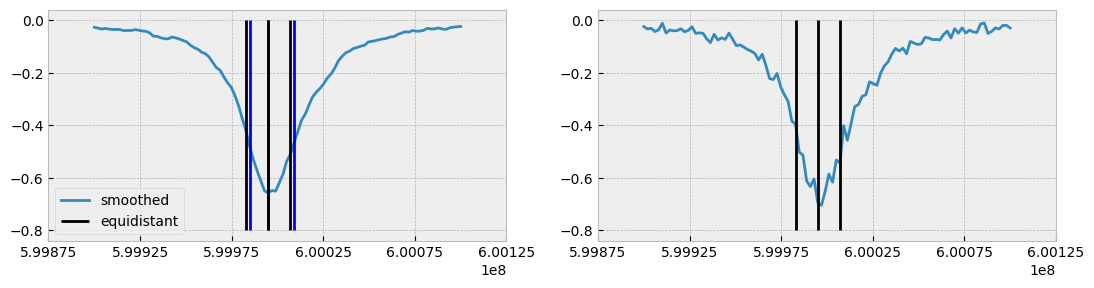

In [7]:
outs = targsweepandfindrpoints(tone_response, True)

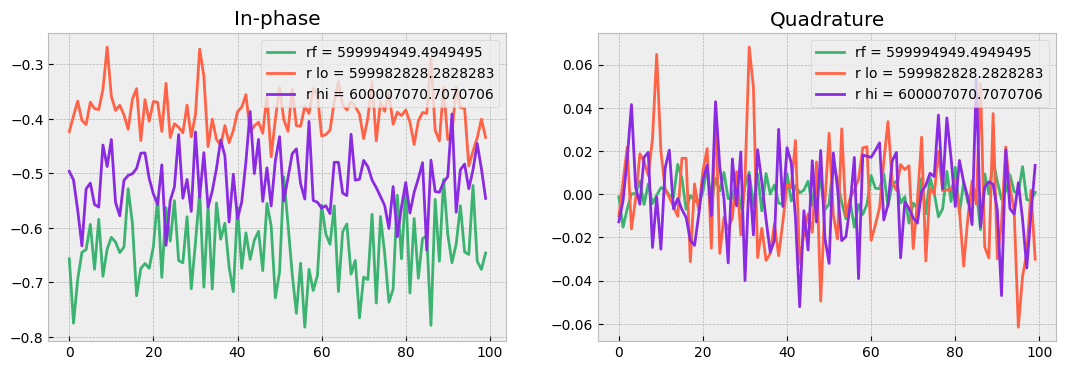

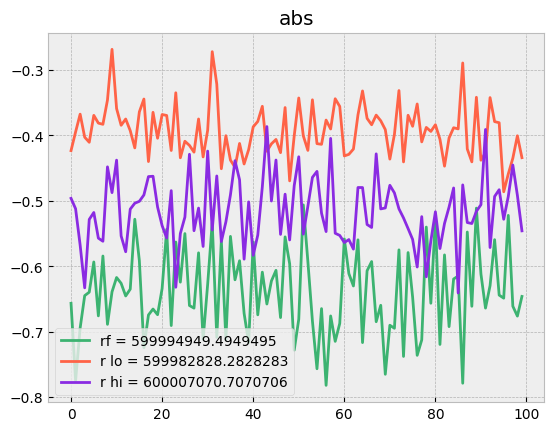

In [8]:
ts_arr = timestreams(*outs[0])

/home/triv/.local/lib/python3.8/site-packages/scipy/signal/_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)


rf: 599996896.8968968
rl: 600005505.5055056
rr: 599986886.8868868
diffs: 8608.608608722687 10010.010010004044 delta: 9309.309309363365
d_lo 599987587.5875875
d_hi 600006206.2062062


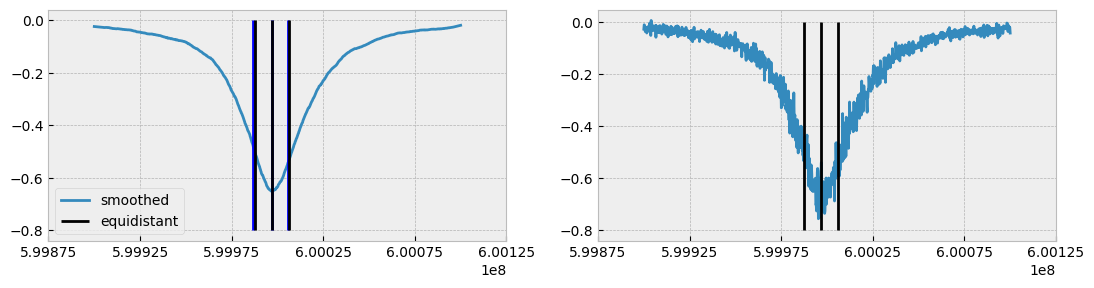

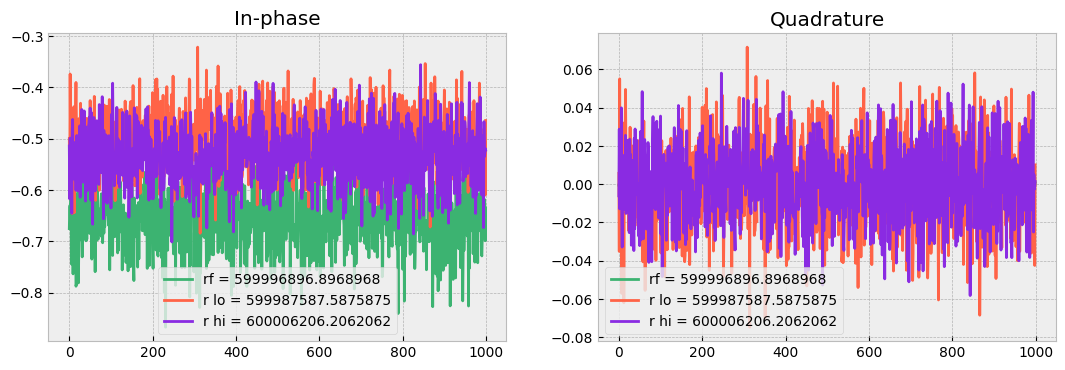

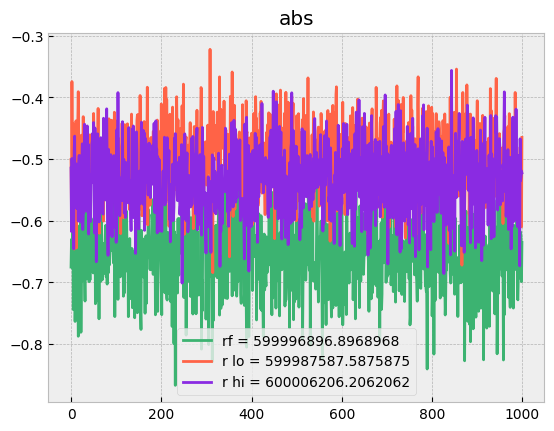

In [31]:
outs2 = targsweepandfindrpoints(tone_response, True,N=1000)
ts_arr2 = timestreams(*outs2[0],N=1000)

(-0.21104862479220032,
 0.21691551872480486,
 -0.08214956287460483,
 0.06337357649939232)

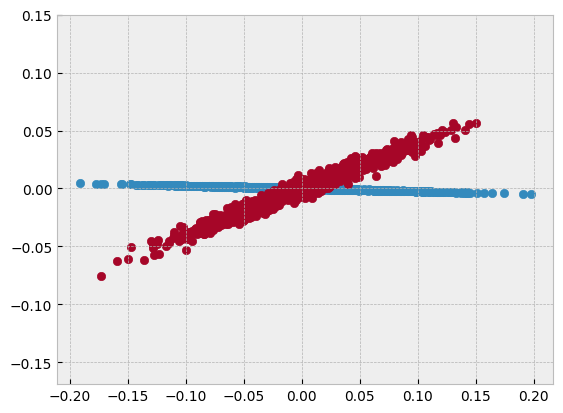

In [10]:
plt.scatter(ts_arr2[0].real - np.mean(ts_arr2[0].real), ts_arr2[0].imag - np.mean(ts_arr2[0].imag))
plt.scatter(ts_arr2[1].real - np.mean(ts_arr2[1].real), ts_arr2[1].imag - np.mean(ts_arr2[1].imag))
#plt.scatter(ts_arr2[3].real, ts_arr2[3].imag)
plt.axis('equal')

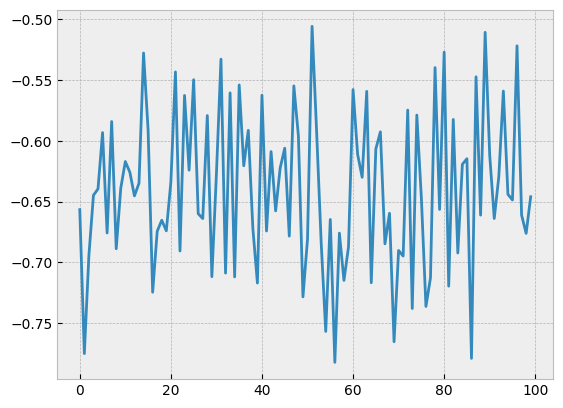

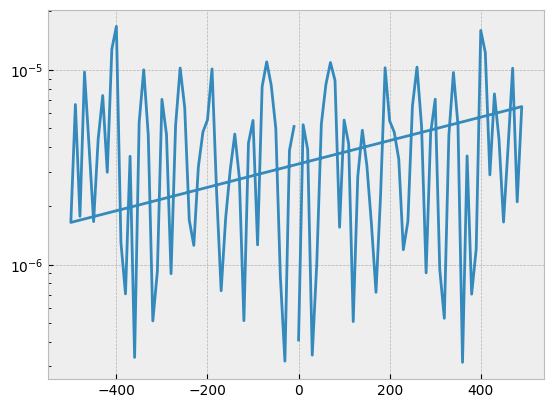

In [35]:
from scipy import signal
plt.plot(ts_arr[0])
plt.show()
f, Pxx = signal.welch(ts_arr[0], 1e3, average='median')
plt.semilogy(f, Pxx)
plt.show()

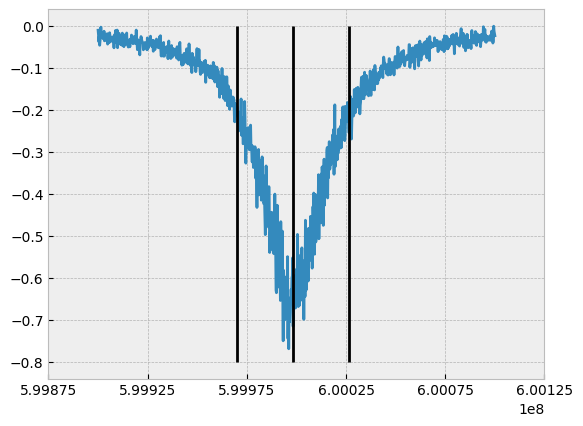

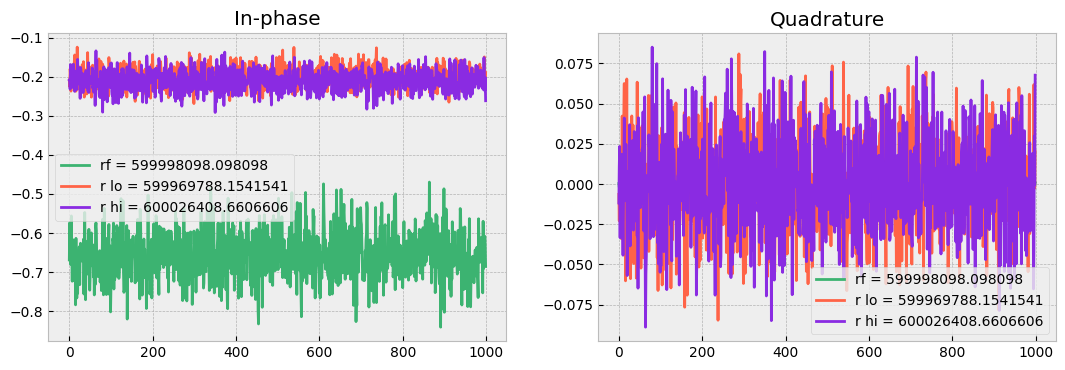

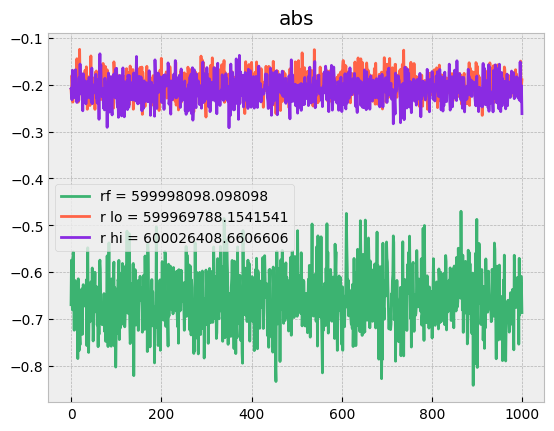

In [12]:
def usingthissoidontlitterglobalnamespace():
    rf, d_lo, d_hi = outs2[0]
    this_range, targ = outs2[1]
    d_lo = 0.99997*d_lo
    d_hi = 1.00003*d_hi
    
    fig, ax = plt.subplots()
    ax.plot(this_range, targ)
    ax.vlines([rf, d_lo, d_hi], -0.8, 0, 'k')
    ax.set_xticks(ax.get_xticks()[::2])
    plt.show()

    ts_arr3 = timestreams(rf, d_lo, d_hi ,N=1000)


    
    return

usingthissoidontlitterglobalnamespace()

#### Playground

In [13]:
prin

NameError: name 'prin' is not defined

In [ ]:
out = modelKid(f=np.linspace(5.99e8, 6.01e8, 1000), P=0.05*np.ones(1000), f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)
plt.plot(out[0])
plt.show()
plt.plot(out[1])
plt.show()

In [ ]:
#testing smoothing
from scipy.signal import savgol_filter as sf
vv = (out[0]+out[1])[300:700]

plt.plot(vv)
plt.show()
plt.plot(np.cumsum(vv)/(1+np.arange(len(vv))))
plt.show()
#plt.plot(sf(vv, 20, 1))
plt.plot(sf(vv, int(np.floor(0.05*len(vv))), 1))
plt.show()

In [ ]:
plt.plot(np.abs(out[0]))
plt.plot(out[1].imag)

In [ ]:
np.arange(4)

In [ ]:
targy = []
te = np.linspace(5.999e8, 6.001e8, 100)
for i in te:
    targy.append(tone_response(i, 0.05))

In [ ]:
tt = np.array(targy)
plt.plot(tt)

In [ ]:
plt.plot(sf(targy, int(np.floor(0.05*len(targy))), 1))

In [ ]:
np.round(0.05*10001)

In [ ]:
600010410.4104104 * 1.00005

In [ ]:
ptri = [1+5j, 2, 3+2j]
np.abs(ptri)

In [ ]:
plt.plot(out[0].imag)

In [ ]:
### Adding noise

plt.plot(1 - out[0].real)

noise_weight = np.max(S21) - S21 
noise_weight = noise_weight / np.max(noise_weight)
noise = np.random.normal(0, 0.003*(1/P[0]), size=len(S21)) #0.001*(1/P[0])
noise = noise * noise_weight